In [1]:
# @title
### EP2 MAC0417 / MAC5768 ##################################################
#  AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP,              #
#  DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELAS RESPOSTAS NESTA LISTA.    #
#  TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM, SEGUINDO AS    #
#  INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM DESONESTIDADE ACADÊMICA OU PLÁGIO.#
#                                                                              #
#  DECLARO TAMBÉM QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS                      #
#  DESSE PROGRAMA E QUE EU NÃO DISTRIBUI OU FACILITEI A                        #
#  SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E                     #
#  DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS                 #
#  DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                                        #
#  ENTENDO QUE LISTAS SEM ASSINATURA NÃO SERÃO CORRIGIDAS E,                   #
#  AINDA ASSIM, PODERÃO SER PUNIDOS POR DESONESTIDADE ACADÊMICA.               #
#                                                                              #
#  Nome : Érico Tiago Meireles                                                 #
#  NUSP : 9312428                                                              #
#  Turma: MAC5768 Visão e Processamento de Imagens                             #
#  Prof.: Ronaldo Fumio Hashimoto                                              #
################################################################################

## EP2 - Data Augmentation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import cv2

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

#### Importa os metadados

In [3]:
metadata = pd.read_csv(rf"../metadados.csv", sep=';')

#### Criação da tabela sumária geral:

In [4]:
# Define uma nova coluna "classe" para agrupar todas as classes presentes em cada imagem

metadata['classe'] = metadata['classe_1']

for i in range(2, 6):
    metadata['classe'] += ', ' + metadata.apply(lambda row: row['classe_' + str(i)] if pd.notnull(row['classe_' + str(i)]) else '', axis=1)

# Remove ',' no final do string
metadata['classe'] = metadata['classe'].str.rstrip(', ')

In [5]:
# Separa as palavras por vírgula e cria uma lista única de palavras
palavras_unicas = set(palavra.strip() for palavra in ','.join(metadata['classe']).split(',') if palavra)
# Converte o conjunto de volta para uma lista
lista_palavras_unicas = list(palavras_unicas)

In [6]:

def get_folder_size(path):
    # Define o tamanho de uma pasta

    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Converte bytes para megabytes

# retorna tamanho em MB das fotos reescaladas
tamanho_mb = get_folder_size("../data_resized/")

In [7]:
def get_image_resolutions(path):

    # pega a resolução das imagens no diretório de interesse
    resolutions = []
    for filename in os.listdir(path):
        if filename.lower().endswith('.jpeg'):  # Exemplo para imagens PNG
            image_path = os.path.join(path, filename)
            image = plt.imread(image_path)
            resolutions.append(image.shape[:2])  # (linhas, colunas)
    return pd.DataFrame(resolutions, columns=['Linhas', 'Colunas'])

# Obtem a resolução média (linhas x Colunas)
resolucoes_df = get_image_resolutions("../data_resized/")
linhas = (sum(resolucoes_df['Linhas'])/len(resolucoes_df['Linhas']))
colunas = (sum(resolucoes_df['Colunas'])/len(resolucoes_df['Colunas']))

##### TABELA SUMÁRIA

In [8]:
print(
    f'''
#############################################
    
Tabela Global sumária:
    > Nome das classes: {lista_palavras_unicas}
    > Número das classes: {len(lista_palavras_unicas)}
    > Número de imagens: {len(metadata)}
    > Tamanho da base: {round(tamanho_mb, 2)} MB
    > Resolução das imagens: {round(linhas, 0)} linhas X {round(colunas, 0)} colunas
    
#############################################
'''
)


#############################################
    
Tabela Global sumária:
    > Nome das classes: ['som', 'pilha', 'caneta', 'colher', 'capacete', 'protetor solar', 'garfo', 'caneca', 'faca', 'livro']
    > Número das classes: 10
    > Número de imagens: 109
    > Tamanho da base: 5.38 MB
    > Resolução das imagens: 600.0 linhas X 800.0 colunas
    
#############################################



#### Criação da Tabela Detalhada por Classe 

In [9]:
resumos = []

# Iterando pelas palavras únicas
for classe in lista_palavras_unicas:
    # Filtrando o dataframe para linhas que contêm a classe
    filtered_df = metadata[metadata['classe'].str.contains(classe, na=False)]

    # Contando a quantidade de cada objeto por foto
    # Inicializando listas para armazenar as contagens
    counts = []
    
    # Splitando a coluna "classe" para contar a quantidade de cada objeto por foto
    counts = filtered_df['classe'].str.split(', ')
    counts = counts.apply(lambda x: len(x))
    
    
    # Calculando a quantidade mínima e máxima de objetos por foto
    min_count = min(counts)
    max_count = max(counts)
    
    # Verificando as variações de fundo e iluminação
    fundos = filtered_df['fundo'].unique()
    iluminacoes = filtered_df['iluminacao'].unique()
    
    # Calculando o número total de fotos e repetições
    total_fotos = len(filtered_df)

    # Calculando as repetições para cada fundo e cada iluminação
    repeticoes_fundos = filtered_df.groupby('fundo')['classe'].apply(lambda x: x.str.count(classe).sum()).to_dict()
    repeticoes_iluminacoes = filtered_df.groupby('iluminacao')['classe'].apply(lambda x: x.str.count(classe).sum()).to_dict()
    
    # Criando o resumo e adicionando à lista
    resumo = {
        'Objeto': classe,
        'Min_Objetos': min_count,
        'Max_Objetos': max_count,
        'Variações_Fundo': len(fundos),
        'Fundos': ', '.join(fundos),
        'Repetições_Fundos': repeticoes_fundos,
        'Variações_Iluminação': len(iluminacoes),
        'Iluminações': ', '.join(iluminacoes),
        'Repetições_Iluminações': repeticoes_iluminacoes,
        'Total_Fotos': len(filtered_df)
    }
    resumos.append(resumo)
# Criando o dataframe de resumo
df_resumo = pd.DataFrame(resumos)

##### TABELA DETALHADA POR CLASSE

In [10]:
df_resumo

,Objeto,Min_Objetos,Max_Objetos,Variações_Fundo,Fundos,Repetições_Fundos,Variações_Iluminação,Iluminações,Repetições_Iluminações,Total_Fotos
0,som,3,5,4,"sofa, chao, varanda, preto","{'chao': 10, 'preto': 10, 'sofa': 14, 'varanda': 8}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 5, 'externo-escuro': 17, 'interno-claro': 10, 'interno-escuro': 10}",42
1,pilha,3,5,4,"sofa, chao, varanda, preto","{'chao': 11, 'preto': 12, 'sofa': 11, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 9, 'externo-escuro': 12, 'interno-claro': 12, 'interno-escuro': 12}",45
2,caneta,3,5,4,"chao, sofa, varanda, preto","{'chao': 13, 'preto': 20, 'sofa': 7, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 15, 'externo-escuro': 15, 'interno-claro': 13, 'interno-escuro': 8}",51
3,colher,3,5,4,"sofa, chao, preto, varanda","{'chao': 13, 'preto': 12, 'sofa': 14, 'varanda': 7}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 10, 'externo-escuro': 13, 'interno-claro': 12, 'interno-escuro': 11}",46
4,capacete,3,5,4,"sofa, chao, preto, varanda","{'chao': 7, 'preto': 10, 'sofa': 9, 'varanda': 9}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 6, 'externo-escuro': 13, 'interno-claro': 11, 'interno-escuro': 5}",35
5,protetor solar,3,5,4,"preto, sofa, chao, varanda","{'chao': 11, 'preto': 9, 'sofa': 7, 'varanda': 12}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 6, 'externo-escuro': 10, 'interno-claro': 13, 'interno-escuro': 10}",39
6,garfo,3,5,4,"sofa, preto, varanda, chao","{'chao': 9, 'preto': 17, 'sofa': 8, 'varanda': 8}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 8, 'externo-escuro': 9, 'interno-claro': 11, 'interno-escuro': 14}",42
7,caneca,3,5,4,"sofa, chao, preto, varanda","{'chao': 10, 'preto': 10, 'sofa': 10, 'varanda': 12}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 10, 'externo-escuro': 14, 'interno-claro': 8, 'interno-escuro': 10}",42
8,faca,3,5,4,"sofa, preto, chao, varanda","{'chao': 11, 'preto': 12, 'sofa': 11, 'varanda': 11}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 11, 'externo-escuro': 15, 'interno-claro': 9, 'interno-escuro': 10}",45
9,livro,3,5,4,"sofa, chao, preto, varanda","{'chao': 8, 'preto': 14, 'sofa': 10, 'varanda': 9}",4,"interno-claro, interno-escuro, externo-claro, externo-escuro","{'externo-claro': 8, 'externo-escuro': 12, 'interno-claro': 10, 'interno-escuro': 11}",41


### REDIMENSIONAMENTO DE IMAGENS:

Todos as imagens já haviam tido o seu tamanho diminuído no EP1, usando o JN "resize_pics", deixando cada imagem com menos de 50kB, portanto o código seguirá usando essas imagens já menores que o pedido no EP2.

### Transformação das Imagens para tons de Cinza:

In [11]:
# Selecionando aleatoriamente um conjunto de imagens
np.random.seed(42)  # Definindo a semente aleatória para reprodução
sample_imgs = metadata['img'].sample(20, replace=True)  # Selecionando 20 imagens aleatórias do dataframe

# Carregando e plotando as imagens usando a função plot_sample
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def tile(imgs, n=20):
    return np.vstack([np.hstack(img_chunk) for img_chunk in chunks(imgs, n)])

def plot_sample(x):
    nrows = int(np.sqrt(len(x)) + 0.5)
    ncols = len(x) // nrows + (1 if len(x) % nrows != 0 else 0)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(tile(x, ncols),cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()



In [12]:
# Caminho para o diretório das imagens originais e para o diretório das imagens processadas
caminho_imagens_gray = "../data_EP2/originalGrayDataset/"

# Criando o diretório para as imagens processadas se ele não existir
if not os.path.exists(caminho_imagens_gray):
    os.makedirs(caminho_imagens_gray)

In [13]:
def convert_to_grayscale(input_dir, output_dir):
    # Criar diretório de saída se não existir
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Lista de nomes de arquivos das imagens originais
    img_names = os.listdir(input_dir)
    
    # Fórmula para conversão para tons de cinza
    rgb_gray = [0.2989, 0.5870, 0.1140]
    
    for img_name in img_names:
        # Caminho completo para a imagem original e convertida
        img_path_original = os.path.join(input_dir, img_name)
        img_path_gray = os.path.join(output_dir, img_name)
        
        # Carregar a imagem original usando cv2
        img = cv2.imread(img_path_original)
        
        # Verificar se a imagem foi carregada corretamente e se tem 3 canais (RGB)
        if img is not None and img.ndim == 3 and img.shape[2] == 3:
            # Converter para tons de cinza usando a fórmula
            img_gray = np.dot(img[...,:3], rgb_gray)
            
            # Normalizar os valores da imagem para o intervalo [0, 255]
            img_gray = (img_gray / img_gray.max()) * 255
            
            # Salvar a imagem convertida usando cv2
            cv2.imwrite(img_path_gray, img_gray.astype(np.uint8))
    
    print("Imagens convertidas para tons de cinza e salvas com sucesso!")

# Caminho para o diretório das imagens
caminho_imagens = "../data_resized/"

# Converter as imagens para tons de cinza
convert_to_grayscale(caminho_imagens, caminho_imagens_gray)

Imagens convertidas para tons de cinza e salvas com sucesso!


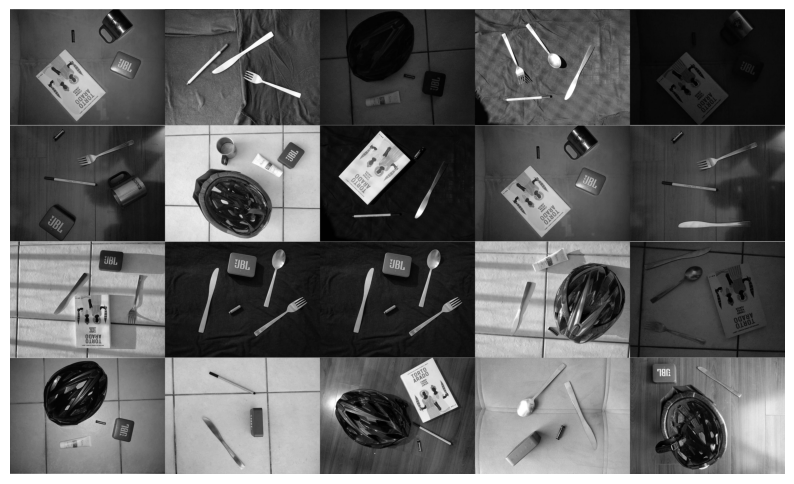

In [14]:

# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_gray, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)

### Data Augmentation:

#### Contrast Stretching:

In [15]:
# Caminho para o diretório das imagens em tons de cinza
caminho_imagens_gray = "../data_EP2/originalGrayDataset/"

# Caminho para o diretório das imagens com contrast stretching
caminho_imagens_contrast_stretched = "../data_EP2/augmentedDataset/stretching/"

# Criando o diretório para as imagens redimensionadas se ele não existir
if not os.path.exists(caminho_imagens_contrast_stretched):
    os.makedirs(caminho_imagens_contrast_stretched)



# Função para aplicar contrast stretching
def contrast_stretching(img):
    p_quantile1, p_quantile2 = np.percentile(img, (5, 95))
    img_contrast_stretched = np.clip(img, p_quantile1, p_quantile2)
    img_contrast_stretched = ((img_contrast_stretched - p_quantile1) / (p_quantile2 - p_quantile1) * 255).astype(np.uint8)
    return img_contrast_stretched

# Processando e salvando as imagens

# Lista de nomes de arquivos das imagens originais
img_names = os.listdir(caminho_imagens_gray)

for img_name in img_names:
    img_path_original = os.path.join(caminho_imagens_gray, img_name)
    img_path_stretched = os.path.join(caminho_imagens_contrast_stretched, img_name)
    
    # Carregando a imagem original em tons de cinza
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original)
        
        # Aplicando contrast stretching
        img_contrast_stretched = contrast_stretching(img_gray)
        
        # Salvando a imagem processada
        cv2.imwrite(img_path_stretched, img_contrast_stretched.astype(np.uint8))

print("Imagens processadas e salvas com sucesso!")



Imagens processadas e salvas com sucesso!


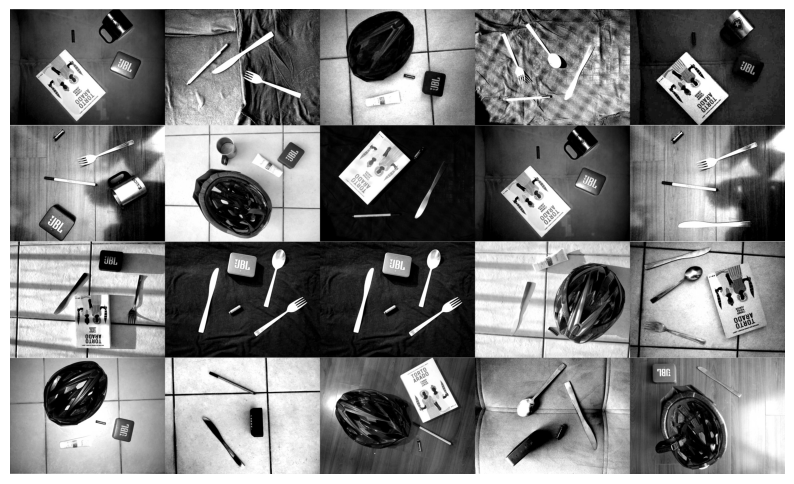

In [16]:

# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_contrast_stretched, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)

#### Logaritmo da imagem

In [17]:
# Caminho para o diretório das imagens originais e para o diretório das imagens processadas
caminho_imagens_logaritmo = "../data_EP2/augmentedDataset/logaritmo/"

# Criando o diretório para as imagens processadas se ele não existir
if not os.path.exists(caminho_imagens_logaritmo):
    os.makedirs(caminho_imagens_logaritmo)


# Definir os valores de c para diferentes tipos de iluminação
iluminacao_to_c = {
    'interno-claro': 1,    
    'interno-escuro': 5,    
    'externo-claro': 1.2,    
    'externo-escuro': 7     
}


def log_transformation(img, c):

    # Definir a intensidade da imagem transformada sendo: s = c * log(1 + r)
    # r é a intensidade da imagem original
    
    log_img = c * np.log1p(img)

    # Normalização da transformação log para o range de [0, 255]

    log_img = (log_img - np.min(log_img)) / (np.max(log_img) - np.min(log_img)) * 255

    return log_img.astype(np.uint8)




In [18]:
# Processar e salvar as imagens
for _, row in metadata.iterrows():
    img_name = row['img']
    iluminacao = row['iluminacao']
    
    # Obter o valor de c com base na iluminação
    c = iluminacao_to_c.get(iluminacao, 1)  # Usar 1 como padrão se a iluminação não for encontrada

    # Caminho completo para a imagem original e a imagem processada
    img_path_original = os.path.join(caminho_imagens_gray, img_name)

    img_path_log = os.path.join(caminho_imagens_logaritmo, img_name)
    
    # Carregar a imagem original em tons de cinza
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original, cv2.IMREAD_GRAYSCALE)

        # Aplicar a transformação logarítmica

        img_log = log_transformation(img_gray, c)
        
        # Salvar a imagem processada
        cv2.imwrite(img_path_log, img_log.astype(np.uint8))
    

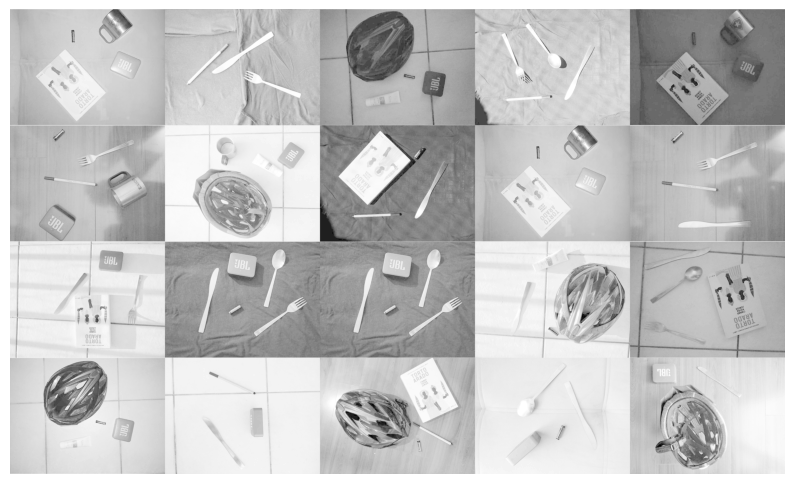

In [19]:
# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_logaritmo, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)

#### Exponencial da imagem

In [20]:
# Paths for original and processed images
caminho_imagens_exponencial = "../data_EP2/augmentedDataset/exponencial/"

# Create directory for processed images if it doesn't exist
if not os.path.exists(caminho_imagens_exponencial):
    os.makedirs(caminho_imagens_exponencial)

# Define the parameters c and gamma for different types of illumination
iluminacao_to_params = {
    'interno-claro': (0.5, 0.5),
    'interno-escuro': (1.5, 0.5),
    'externo-claro': (0.8, 0.8),
    'externo-escuro': (2, 1.5)
}

In [21]:
def gamma_transform(image_array, c, gamma):

  # Definir a intensidade da imagem transformada sendo: s = c * r^gamma
  # r é a intensidade da imagem original

  gamma_img = c * np.power(image_array, gamma)

  # Normalização da transformação gamma para o range de [0, 255]
  gamma_img = (gamma_img - np.min(gamma_img)) / (np.max(gamma_img) - np.min(gamma_img)) * 255

  return gamma_img

In [22]:
for _, row in metadata.iterrows():
    img_name = row['img']
    iluminacao = row['iluminacao']
    
    # Get the values of c and gamma based on illumination
    c, gamma = iluminacao_to_params.get(iluminacao, (1, 1))  # Use (1, 1) as default if illumination is not found
    # Full paths for original and processed images
    img_path_original = os.path.join(caminho_imagens_gray, img_name)
    img_path_exp = os.path.join(caminho_imagens_exponencial, img_name)
    
    # Load the original grayscale image
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original, cv2.IMREAD_GRAYSCALE)
        
        # Apply exponential transformation
        img_exp = gamma_transform(img_gray, c, gamma)
        
        # Save the processed image
        cv2.imwrite(img_path_exp, img_exp)

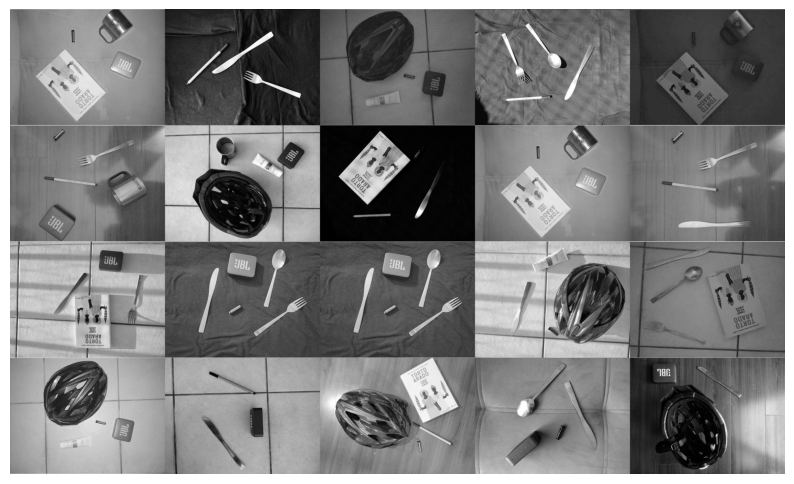

In [23]:
# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_exponencial, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)

#### Laplaciano da imagem

In [24]:
# Paths for original and processed images
caminho_imagens_laplaciano = "../data_EP2/augmentedDataset/laplaciano/"

# Create directory for processed images if it doesn't exist
if not os.path.exists(caminho_imagens_laplaciano):
    os.makedirs(caminho_imagens_laplaciano)

# Definir o kernel do operador Laplaciano
interest_kernel = np.array([[0, 1, 0],
                            [1, -4, 1],
                            [0, 1, 0]])

In [25]:

def laplacian(img, kernel):
    
    # Aplicar o filtro convolucional
    # Aplicar o filtro convolucional
    laplacian_img = np.abs(np.convolve(img.flatten(), kernel.flatten(), mode='same'))
    
    # Normalização da imagem resultante para o intervalo [0, 255]
    laplacian_img = (laplacian_img - np.min(laplacian_img)) / (np.max(laplacian_img) - np.min(laplacian_img)) * 255
    laplacian_img = laplacian_img.astype(np.uint8)
    
    # Redimensionar para a forma original da imagem
    laplacian_img = laplacian_img.reshape(img.shape)
    
    return laplacian_img



# Processando e salvando as imagens

# Lista de nomes de arquivos das imagens originais
img_names = os.listdir(caminho_imagens_gray)

for img_name in img_names:
    img_path_original = os.path.join(caminho_imagens_gray, img_name)
    img_path_laplacian = os.path.join(caminho_imagens_laplaciano, img_name)
    
    # Carregando a imagem original em tons de cinza
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original)
        
        # Aplicando contrast stretching
        img_laplacian = laplacian(img_gray, interest_kernel)
        
        # Salvando a imagem processada
        cv2.imwrite(img_path_laplacian, img_laplacian.astype(np.uint8))

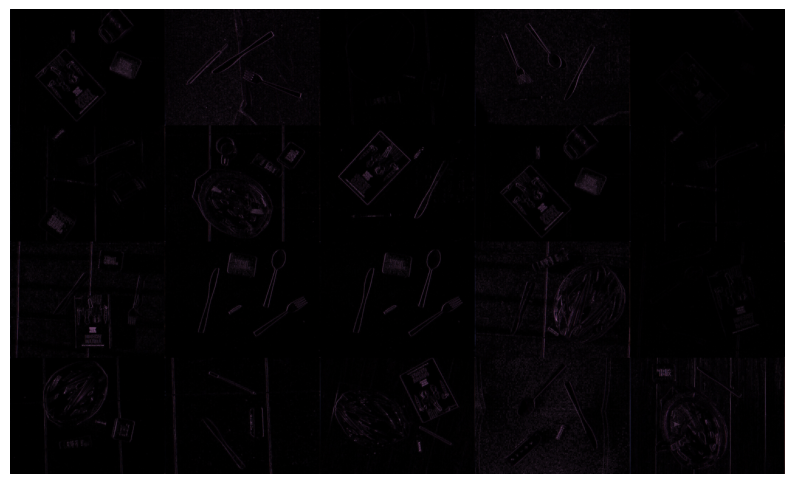

In [26]:
# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_laplaciano, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)

#### Filtro da média implementado usando convolução.

In [27]:
# Paths for original and processed images
caminho_imagens_media = "../data_EP2/augmentedDataset/media/"

# Create directory for processed images if it doesn't exist
if not os.path.exists(caminho_imagens_media):
    os.makedirs(caminho_imagens_media)

# Definir o kernel do Filtro de média
interest_kernel = 1/9 * np.array([[1, 1, 1],
                                [1, 1, 1],
                                [1, 1, 1]])

In [28]:
def median_filter(img, kernel):
    
    
    # Aplicar o filtro convolucional
    # Aplicar o filtro convolucional
    avg_img = np.abs(np.convolve(img.flatten(), kernel.flatten(), mode='same'))
    
    # Normalização da imagem resultante para o intervalo [0, 255]
    avg_img = (avg_img - np.min(avg_img)) / (np.max(avg_img) - np.min(avg_img)) * 255
    avg_img = avg_img.astype(np.uint8)
    
    # Redimensionar para a forma original da imagem
    avg_img = avg_img.reshape(img.shape)
    
    return avg_img


# Processando e salvando as imagens

# Lista de nomes de arquivos das imagens originais
img_names = os.listdir(caminho_imagens_gray)

for img_name in img_names:
    img_path_original = os.path.join(caminho_imagens_gray, img_name)
    img_path_media = os.path.join(caminho_imagens_media, img_name)
    
    # Carregando a imagem original em tons de cinza
    if os.path.exists(img_path_original):
        img_gray = cv2.imread(img_path_original)
        
        # Aplicando contrast stretching
        img_media = laplacian(img_gray, interest_kernel)
        
        # Salvando a imagem processada
        cv2.imwrite(img_path_media, img_media.astype(np.uint8))


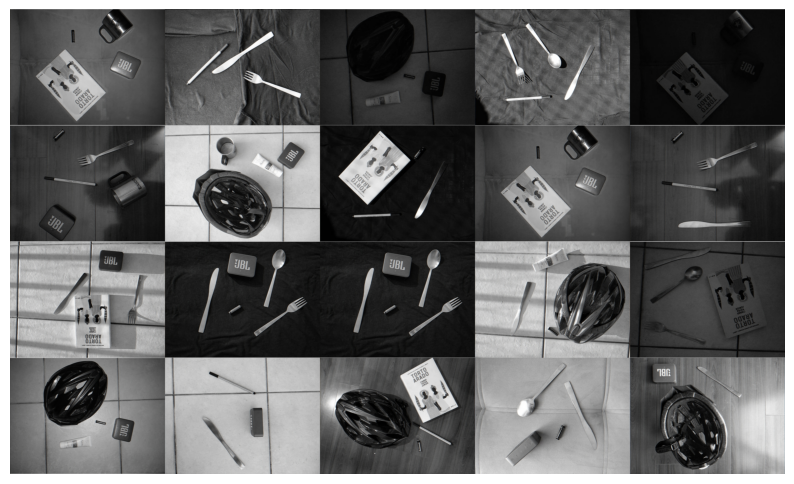

In [29]:
# Carregando e plotando as imagens selecionadas
figuras = [mpimg.imread(os.path.join(caminho_imagens_media, img_name)) for img_name in sample_imgs if os.path.exists(os.path.join(caminho_imagens, img_name))]
plot_sample(figuras)